In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df = pd.read_csv('german.data', sep='\s+')
df.head(2)

,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1.1
0,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
1,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1


In [8]:
column_names = ['checking_account', 'duration_month', 'credit_history', 'credit_purpose','credit_amount','savings_account','present_employment','disposable_income_percent',
 'status_sex','debtors','residence_since','property','age','other_installments', 'housing','credits_at_current_bank','job','dependants','telephone', 'foreign_worker','class']

In [9]:
df.columns = column_names
df.head(2)

,checking_account,duration_month,credit_history,credit_purpose,credit_amount,savings_account,present_employment,disposable_income_percent,status_sex,debtors,...,property,age,other_installments,housing,credits_at_current_bank,job,dependants,telephone,foreign_worker,class
0,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
1,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   checking_account           999 non-null    object
 1   duration_month             999 non-null    int64 
 2   credit_history             999 non-null    object
 3   credit_purpose             999 non-null    object
 4   credit_amount              999 non-null    int64 
 5   savings_account            999 non-null    object
 6   present_employment         999 non-null    object
 7   disposable_income_percent  999 non-null    int64 
 8   status_sex                 999 non-null    object
 9   debtors                    999 non-null    object
 10  residence_since            999 non-null    int64 
 11  property                   999 non-null    object
 12  age                        999 non-null    int64 
 13  other_installments         999 non-null    object
 14  housing   

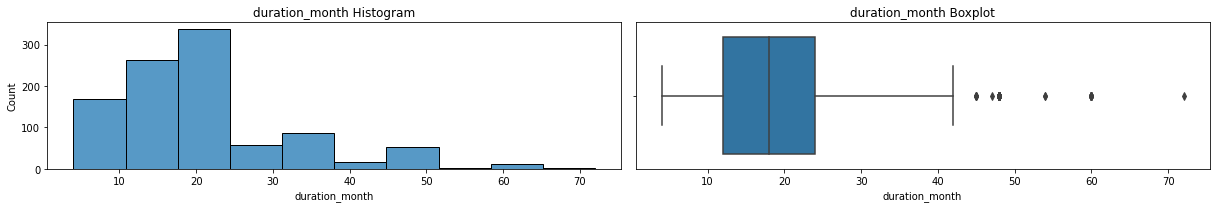

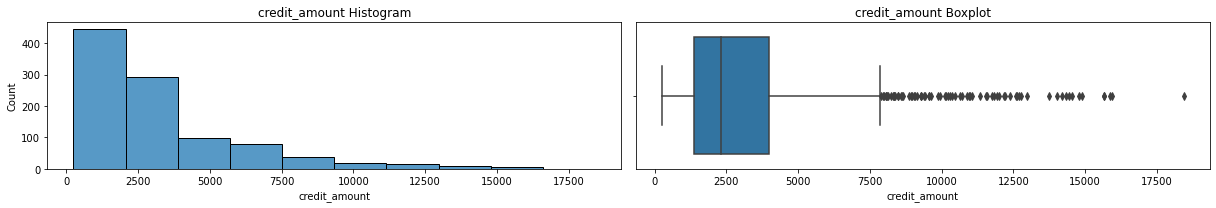

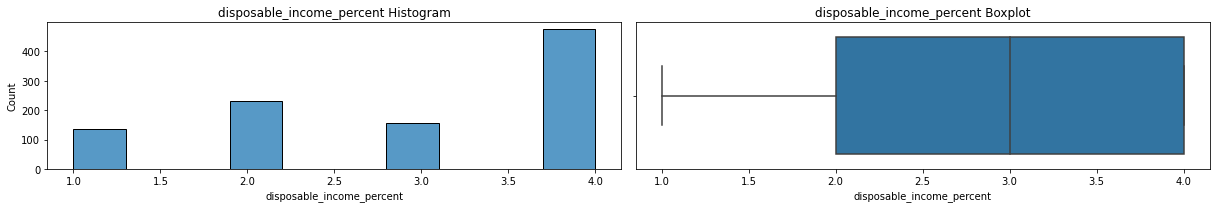

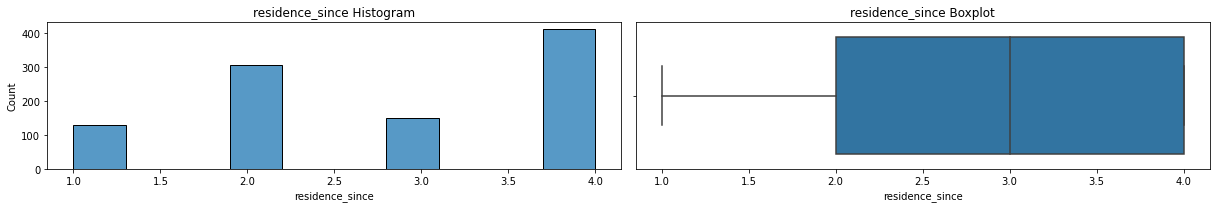

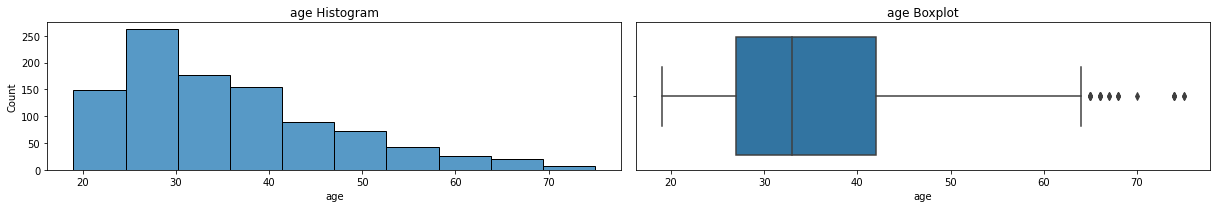

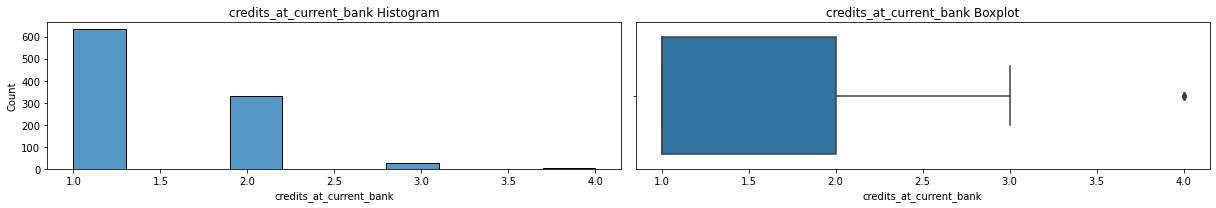

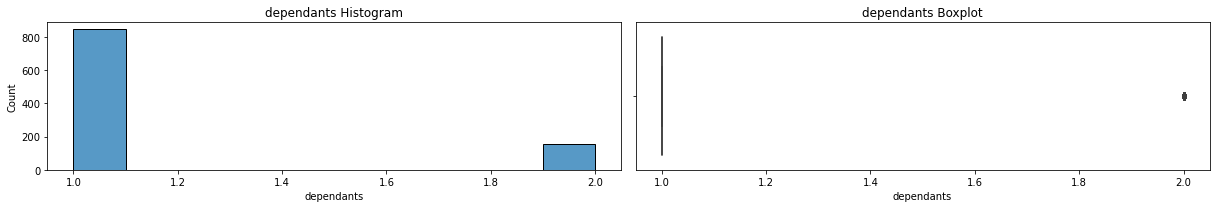

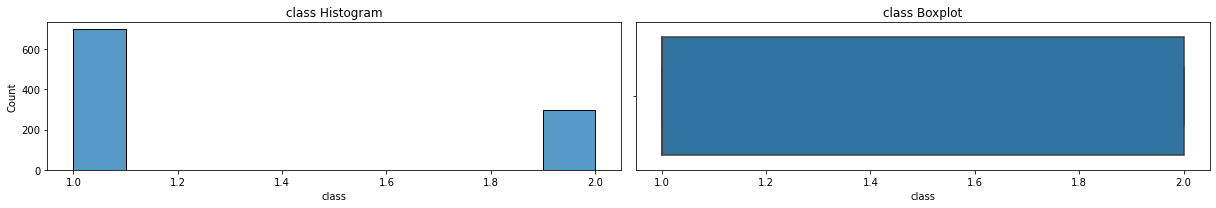

In [77]:
for i in df.columns:
    if df[i].dtype == 'int64':
        fig, ax = plt.subplots(1, 2, figsize=(17, 3))

        sns.histplot(data=df, x=i, bins=10, ax=ax[0])
        ax[0].set_title(f'{i} Histogram')
      

        sns.boxplot(data=df, x=i, ax=ax[1])
        ax[1].set_title(f'{i} Boxplot')
   
        plt.tight_layout()
        plt.show();

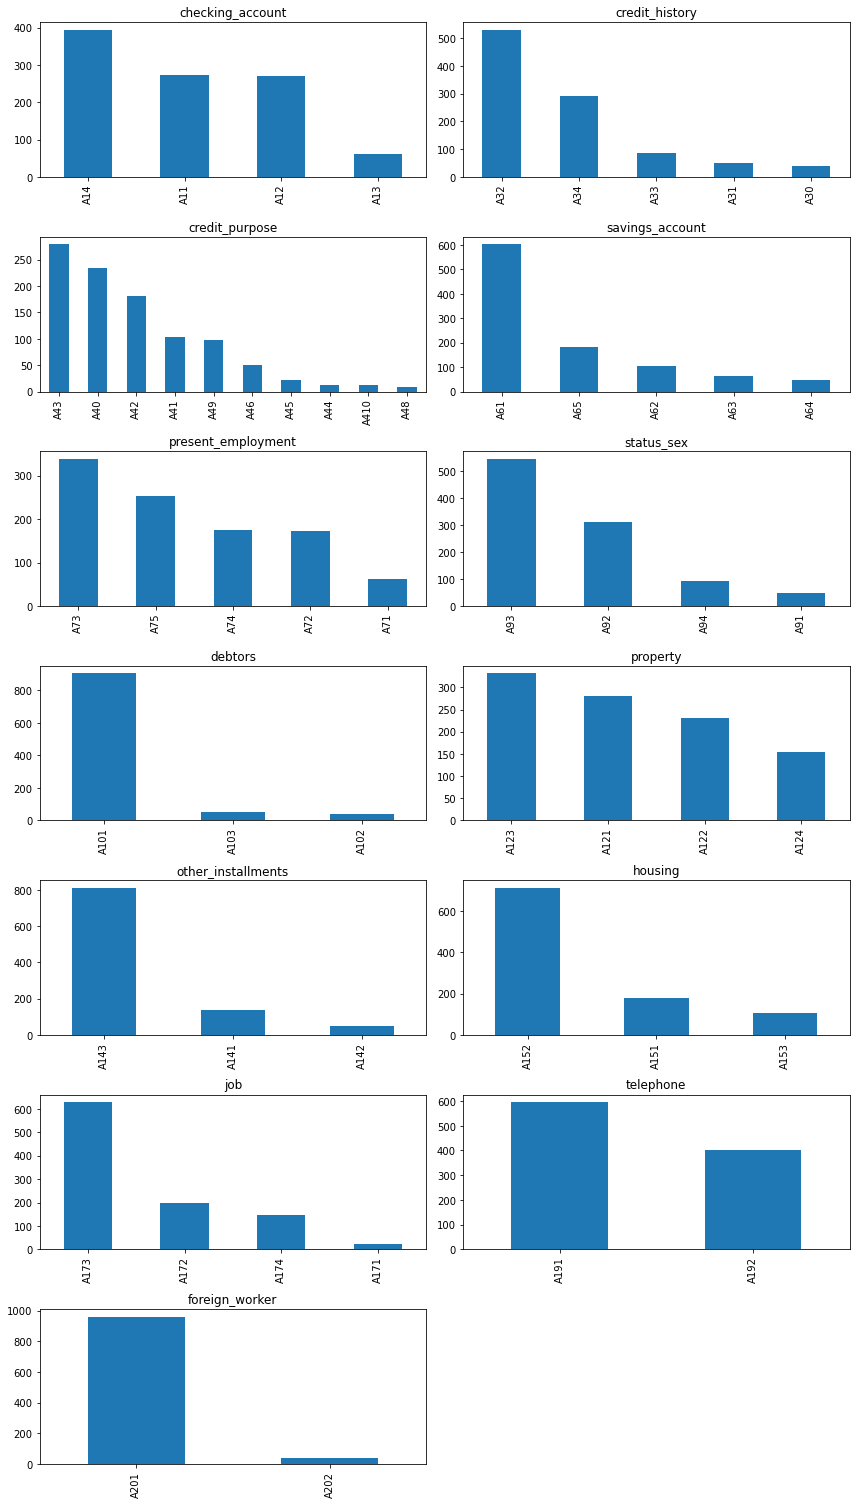

In [102]:
object_columns = df.select_dtypes(include='object').columns

num_rows = (len(object_columns) + 1) // 2  

fig, axes = plt.subplots(num_rows, 2, figsize=(12, 3*num_rows))

axes = axes.flatten()

for i, col in enumerate(object_columns):
    df[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(col)

for i in range(len(object_columns), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

<AxesSubplot:>

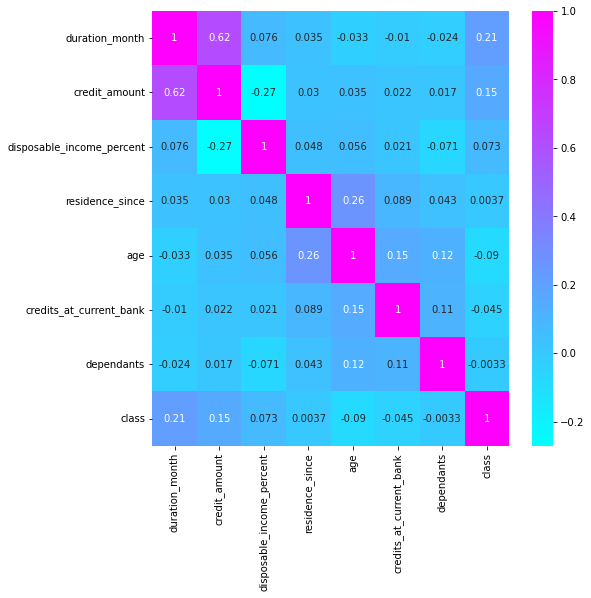

In [38]:
corr_matr = df.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr_matr, cmap= 'cool', annot= True)